### Notebook for the label transfer of Healthy Human Heart cardiomyocytes to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v231127

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources NA
ipykernel         

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [6]:
reference_all = sc.read_h5ad('../../data/hca_heart_global_ctl230918_states_formatted.h5ad')
reference_all

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

In [7]:
reference_all.obs['cell_states'].cat.categories

Index(['Adip1', 'Adip2', 'Adip3', 'Adip4', 'B', 'B_plasma', 'CD14+Mo',
       'CD4+T_Tfh', 'CD4+T_Th1', 'CD4+T_Th17', 'CD4+T_Th2', 'CD4+T_act',
       'CD4+T_naive', 'CD4+T_reg', 'CD69+Mo', 'CD8+T_cytox', 'CD8+T_em',
       'CD8+T_te', 'CD8+T_trans', 'Cycling_T/NK', 'DC2', 'DOCK4+aMØ',
       'DOCK4+vMØ', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap',
       'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria', 'EC8_ln',
       'EC9_FB-like', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6', 'ILC',
       'LYVE1+MØ1', 'LYVE1+MØ2', 'M2MØ', 'MAIT-like', 'Mast', 'Meso', 'MoMø',
       'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'NK_CD16hi', 'NK_CD56hi',
       'NØ', 'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic',
       'SMC2_art', 'TREM2+MØ', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'aCM5', 'gdT',
       'nøMo', 'pDC', 'proIMØ', 'unclassfied.1', 'unclassfied.2', 'vCM1',
       'vCM2', 'vCM3', 'vCM4', 'vCM5'],
      dtype='object')

### Subset population of interest

In [8]:
reference = reference_all[reference_all.obs['cell_states'].isin(['FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6'])]
reference

View of AnnData object with n_obs × n_vars = 58429 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

- Remove annotations with less than 10 cells

In [9]:
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()
reference.obs['seed_labels'].value_counts()

seed_labels
FB1    26632
FB2    13779
FB3     7744
FB4     6146
FB5     2518
FB6     1610
Name: count, dtype: int64

In [10]:
reference.obs['seed_labels'].cat.categories

Index(['FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6'], dtype='object')

In [11]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [12]:
reference.obs['cell_source'].value_counts()

cell_source
Sanger-Nuclei     40521
Harvard-Nuclei    15054
Sanger-Cells       2227
Sanger-CD45         627
Name: count, dtype: int64

### Read in other query

In [13]:
query_all = sc.read_h5ad('../../data/heart_mm_nuclei-23-0092_scANVI-leiden_types_ctl231127.raw.h5ad')
query_all

AnnData object with n_obs × n_vars = 46279 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'C_scANVI_colors', 'cell_type_colors', 'genotype_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

### Subset population of interest

In [14]:
query_all.obs['cell_type'].cat.categories

Index(['FB', 'EC1', 'Mono', 'CM1', 'EC4', 'PC', 'CM2', 'mesCM', 'EC8',
       'Myeloid1', 'EC10', 'MØ', 'lnEC', 'mesFB', 'CD8+T', 'B', 'Myeloid2',
       'CM3'],
      dtype='object')

In [15]:
query = query_all[query_all.obs['cell_type'].isin(['FB', 'mesFB'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 9026 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'C_scANVI_colors', 'cell_type_colors', 'genotype_colors', 'leiden', 'neighbors', 'sample_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [16]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [17]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [18]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 67455 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_type

In [19]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
FB1        26632
FB2        13779
Unknown     9026
FB3         7744
FB4         6146
FB5         2518
FB6         1610
Name: count, dtype: int64

In [20]:
adata.obs['batch'].value_counts()

batch
reference    58429
query         9026
Name: count, dtype: int64

### Select HVGs

In [21]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 67455 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types

### Transfer of annotation with scANVI

In [22]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [23]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [24]:
scvi_model.train(20, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 use_gpu = 0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [01:02<00:00,  2.95s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=2.19e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=2.19e+3]


### Evaluate model performance a la _Sevensson_

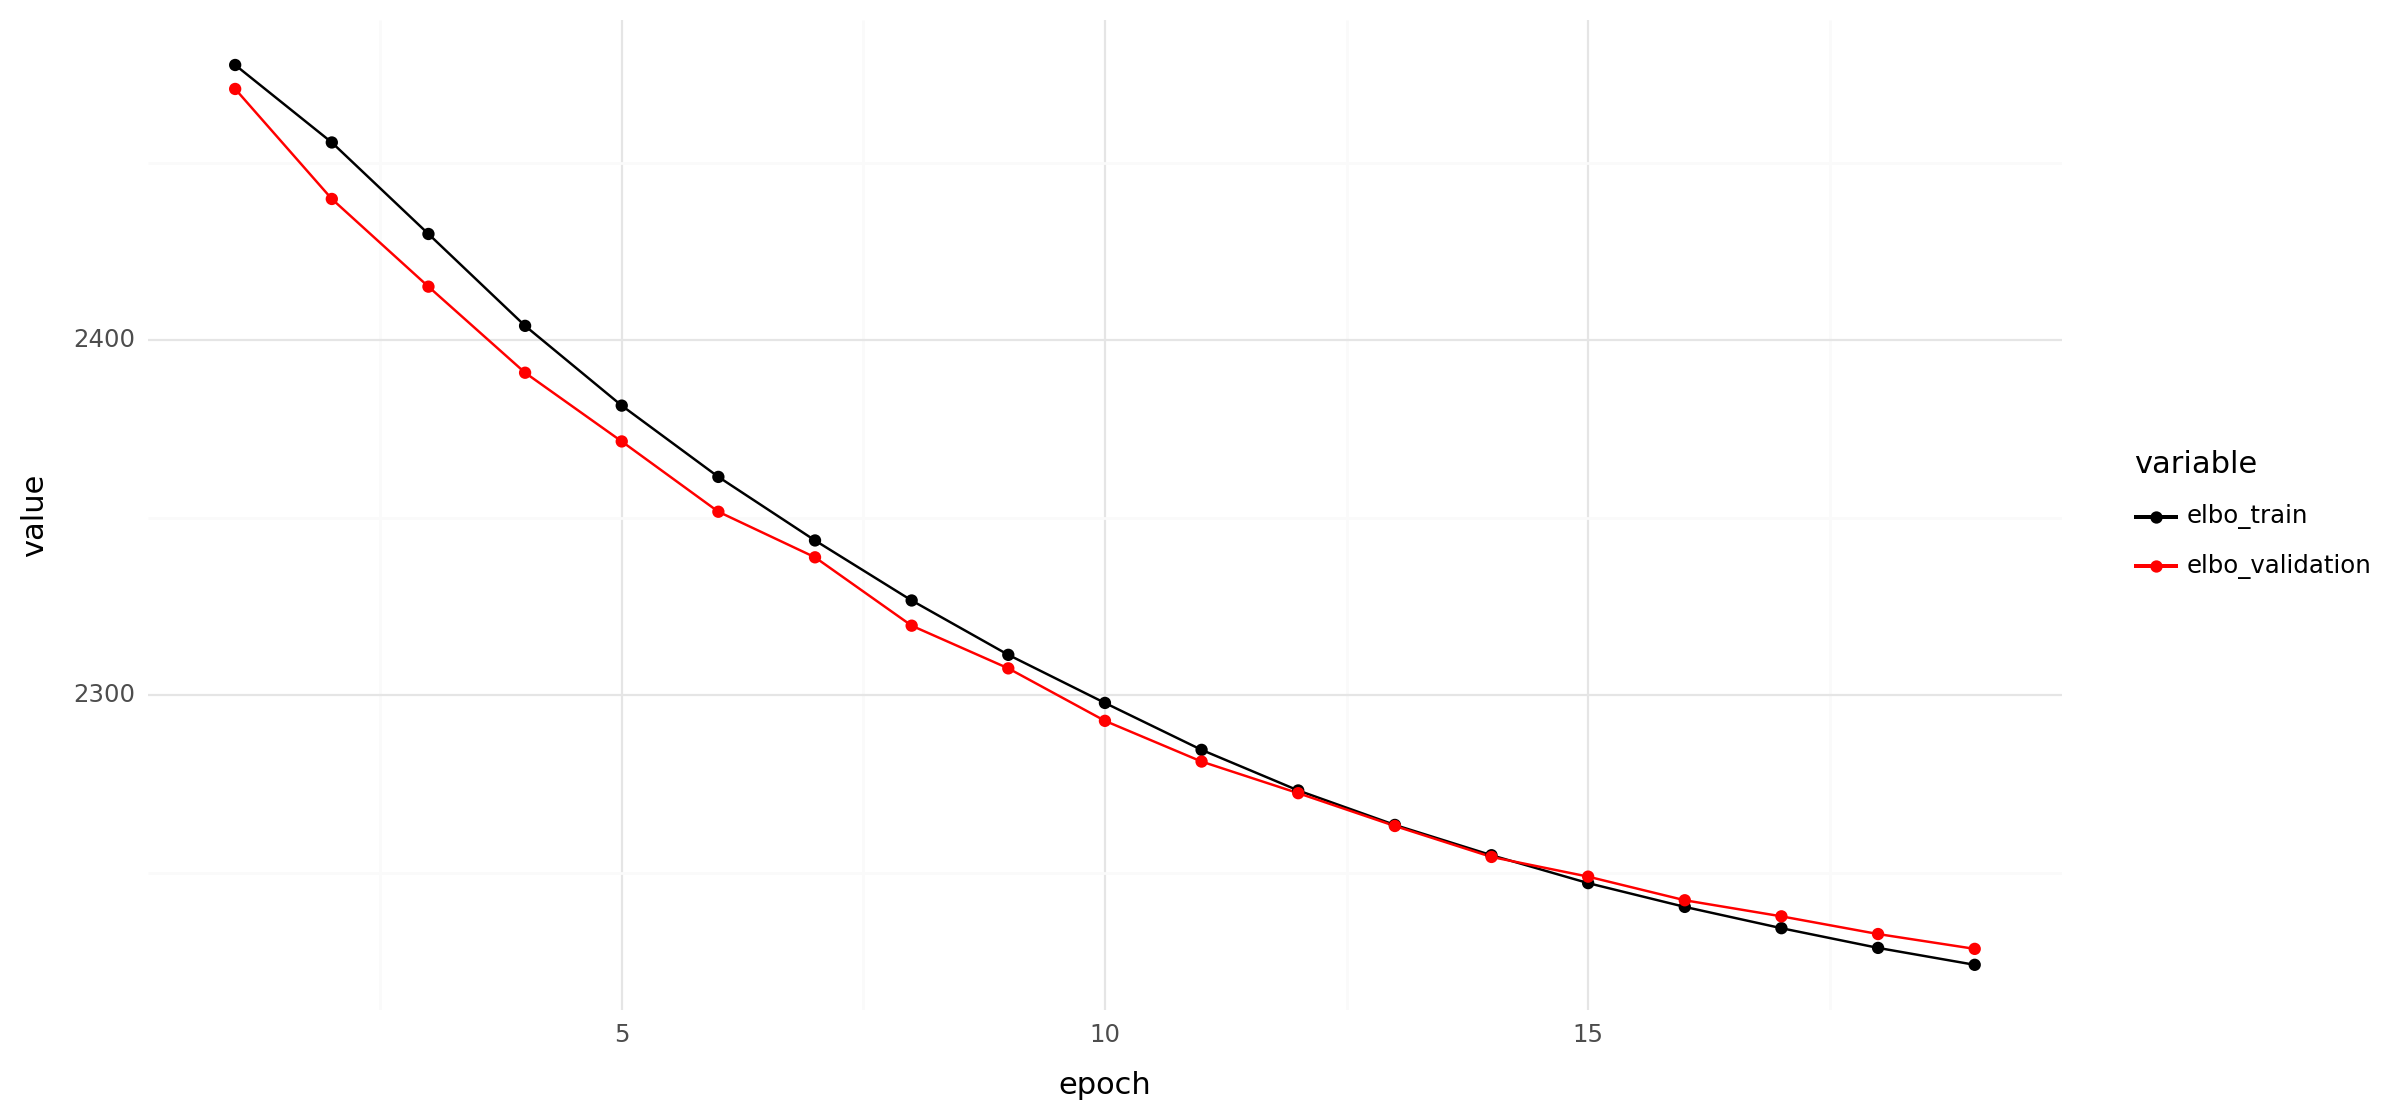

In [25]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [26]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [27]:
scanvi_model.train(100, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True, 
                   use_gpu = 0)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 8/100:   7%|▋         | 7/100 [00:51<11:02,  7.12s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.23e+3]

### Evaluate model performance a la Svensson

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [ ]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

In [ ]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

### Add new gene symbols

In [ ]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

### Revert gene symbols

In [ ]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

In [ ]:
query_export.obs['C_scANVI'].value_counts()

In [ ]:
query_export